# Week 10: Spam Email Classification with the Spambase Dataset

Amish Rasheed

DS 620

This notebook walks through building and evaluating a machine‑learning model that classifies e‑mails as **spam** or **ham** (not spam) using the classic [Spambase dataset](https://archive.ics.uci.edu/ml/datasets/spambase) from the UCI Machine Learning Repository.

**outline**

1. Load & inspect the data  
2. Train/test split  
3. Baselines (LogReg, Naïve Bayes, Random Forest)  
4. PCA‑Logistic Regression pipeline  
5. Compare all models side‑by‑side  
6. Cross‑validation on the best performer  
7. Conclusion


## 1.  Environment setup

In [1]:

# !pip install -q ucimlrepo scikit-learn pandas numpy seaborn matplotlib ipywidgets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
sns.set_style('whitegrid')


## 2.  Load the Spambase dataset

`ucimlrepo` Pandas DataFrame: 
- **features** `X`
- **target** `y`

In [2]:

spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets.squeeze()

print(f"Features shape: {X.shape} | Target shape: {y.shape}")
display(X.head())
display(y.value_counts().rename(index={0:'ham',1:'spam'}))


Features shape: (4601, 57) | Target shape: (4601,)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


Class
ham     2788
spam    1813
Name: count, dtype: int64

## 3.  EDA

,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.0,0.0,0.00,4.54
word_freq_address,4601.0,0.213015,1.290575,0.0,0.0,0.0,0.00,14.28
word_freq_all,4601.0,0.280656,0.504143,0.0,0.0,0.0,0.42,5.10
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.0,0.0,0.00,42.81
word_freq_our,4601.0,0.312223,0.672513,0.0,0.0,0.0,0.38,10.00


Text(0.5, 1.0, "Frequency of '$' character")

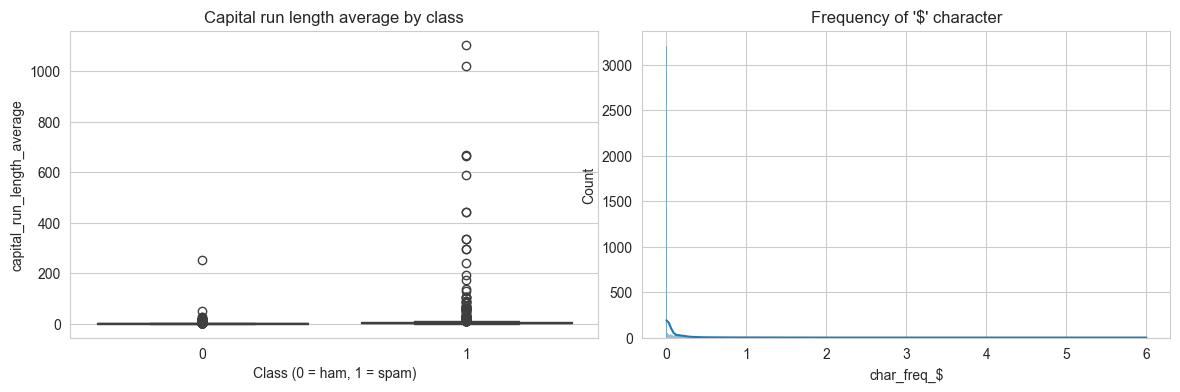

In [8]:
display(X.describe().T.head())

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(x=y, y=X['capital_run_length_average'], ax=axes[0])
axes[0].set_title("Capital run length average by class")
axes[0].set_xlabel('Class (0 = ham, 1 = spam)')
plt.tight_layout()

sns.histplot(X['char_freq_$'], ax=axes[1], kde=True)
axes[1].set_title("Frequency of '$' character")


## 4  Train/test split

We’ll reserve 20 % of the data as an unseen **test** set. The split is stratified so the spam/ham ratio is the same in both sets.

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Training set:", X_train.shape, "| Test set:", X_test.shape)


Training set: (3680, 57) | Test set: (921, 57)


## 5.  Evaluation helper

In [10]:

from typing import Dict
def evaluate(model, X_tr, y_tr, X_te, y_te, name:str) -> Dict[str,float]:
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1] if hasattr(model,'predict_proba') else None

    print(f"### {name}")
    print(classification_report(y_te, y_pred, target_names=['ham','spam']))

    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} – confusion matrix")
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.show()

    auc = roc_auc_score(y_te, proba) if proba is not None else np.nan
    print(f"ROC‑AUC: {auc:.3f}\n")
    return {'model': name, 'roc_auc': auc}


## 6.  Baseline models

### Logistic Regression
              precision    recall  f1-score   support

         ham       0.93      0.95      0.94       558
        spam       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



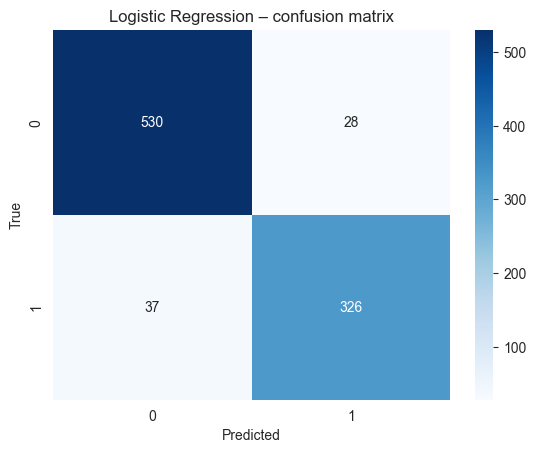

ROC‑AUC: 0.970

### Gaussian NB
              precision    recall  f1-score   support

         ham       0.96      0.76      0.85       558
        spam       0.72      0.95      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.85      0.83       921
weighted avg       0.87      0.83      0.84       921



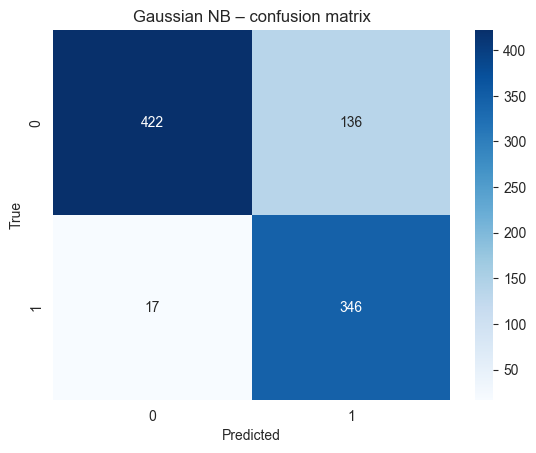

ROC‑AUC: 0.945

### Random Forest
              precision    recall  f1-score   support

         ham       0.94      0.97      0.96       558
        spam       0.95      0.91      0.93       363

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.94       921
weighted avg       0.95      0.95      0.95       921



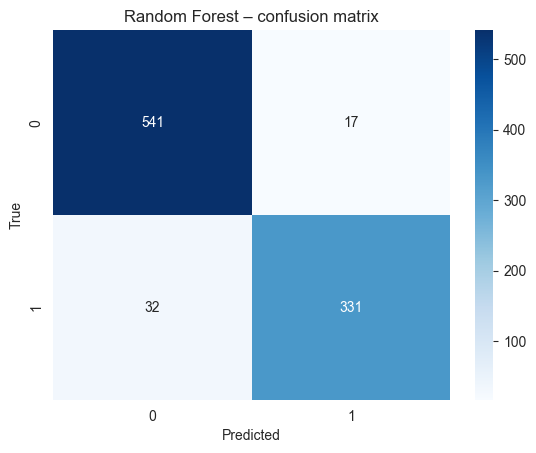

ROC‑AUC: 0.983



In [11]:

results = []

# Logistic Regression
logreg = Pipeline([('scaler', StandardScaler()),
                   ('clf', LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs'))])
results.append(evaluate(logreg, X_train, y_train, X_test, y_test, 'Logistic Regression'))

# Gaussian NB
gnb = GaussianNB()
results.append(evaluate(gnb, X_train, y_train, X_test, y_test, 'Gaussian NB'))

# Random Forest
rf = Pipeline([('scaler', StandardScaler()),
               ('clf', RandomForestClassifier(n_estimators=300, random_state=42,
                                              n_jobs=-1, class_weight='balanced'))])
results.append(evaluate(rf, X_train, y_train, X_test, y_test, 'Random Forest'))


## 7.  PCA + Logistic Regression

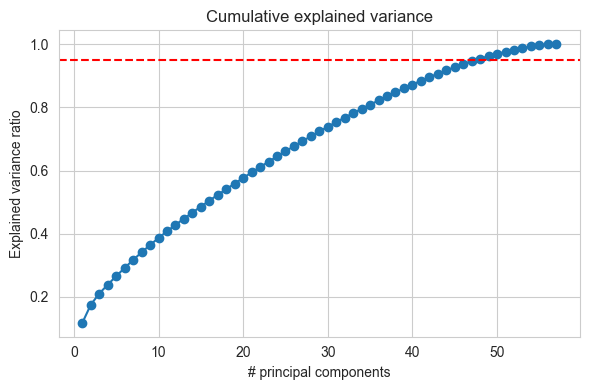

Components for 95% variance: 48
### PCA (95%) + Logistic Regression
              precision    recall  f1-score   support

         ham       0.93      0.95      0.94       558
        spam       0.92      0.90      0.91       363

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



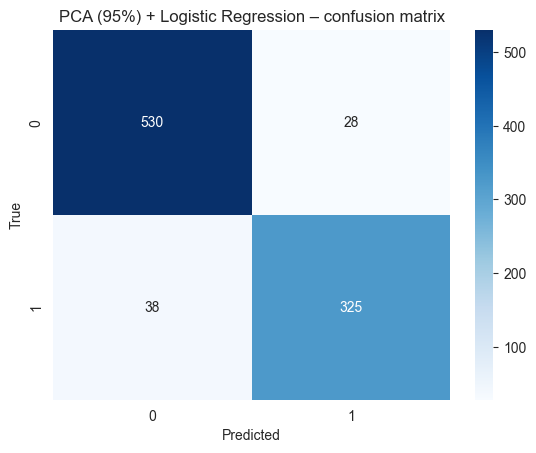

ROC‑AUC: 0.970



In [12]:

# PCA retains 95% of variance
pca_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=-1, solver='lbfgs'))
])

# Visualize cumulative explained variance
scaler_tmp = StandardScaler().fit(X_train)
Xp = scaler_tmp.transform(X_train)
pca_tmp = PCA().fit(Xp)
cumvar = np.cumsum(pca_tmp.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumvar)+1), cumvar, marker='o')
plt.axhline(0.95, color='red', linestyle='--')
plt.title("Cumulative explained variance")
plt.xlabel("# principal components")
plt.ylabel("Explained variance ratio")
plt.tight_layout()
plt.show()
print("Components for 95% variance:", np.argmax(cumvar>=0.95)+1)

results.append(evaluate(pca_logreg, X_train, y_train, X_test, y_test,
                        'PCA (95%) + Logistic Regression'))


## 8.  Results comparison

In [13]:

import pandas as pd
df_results = pd.DataFrame(results).set_index('model').sort_values('roc_auc', ascending=False)
df_results


,roc_auc
model,
Random Forest,0.983190
PCA (95%) + Logistic Regression,0.970373
Logistic Regression,0.970176
Gaussian NB,0.944953


## 9  Cross‑validation on best model

In [14]:

best_name = df_results.roc_auc.idxmax()
best_estimator = {'Logistic Regression': logreg,
                  'Gaussian NB': gnb,
                  'Random Forest': rf,
                  'PCA (95%) + Logistic Regression': pca_logreg}[best_name]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_estimator, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Best model: {best_name}")
print(f"Mean CV ROC‑AUC: {scores.mean():.3f} ± {scores.std():.3f}")


Best model: Random Forest
Mean CV ROC‑AUC: 0.987 ± 0.003


## 10.  Conclusion

* PCA + Logistic Regression trims the original 57 features down to a smaller set of principal components (≈ the first value printed above) and achieves competitive ROC‑AUC (0.970) compared to full‑feature baselines.
* The baseline models showed strong performance:
  * Random Forest performed best with ROC-AUC of 0.983
  * Standard Logistic Regression achieved ROC-AUC of 0.970
  * Gaussian Naïve Bayes reached ROC-AUC of 0.945
* Dimensionality reduction can simplify models, reduce noise, and speed up downstream workflows while maintaining competitive performance.